# Simulating Quantum Circuits & Noise with Aer (Density-Matrix)

**Goal.** Build an intuition-first, reproducible sandbox for **noisy quantum circuits** using Qiskit Aer’s `density_matrix` method.  
We prepare simple states (|+⟩, Bell) and pass them through **physically motivated noise channels** (depolarizing, \\(T_1/T_2\\) relaxation, optional readout error), then quantify the impact via **purity**, **Bloch vectors**, and **fidelity**.

---

## Why density matrices?

Real devices interact with their environment, so pure states \\(|\psi\rangle\\) become **mixed**. The **density matrix** \\(\rho\\) captures both:

- **Noiseless (unitary) evolution:** \\( \rho' = U\rho U^\dagger \\).
- **Noisy (open-system) evolution (Kraus):**  
  \\( \rho' = \sum_k E_k\,\rho\,E_k^\dagger,\quad \sum_k E_k^\dagger E_k = I \\) (CPTP map).

Using `method="density_matrix"` simulates \\(\rho\\) directly, letting us apply realistic channels **gate-by-gate**.

---

## Noise channels modeled

### 1) Depolarizing (basis-agnostic mixing)
For 1-qubit states:
\\[
\mathcal{E}_{\text{dep}}(\rho) = (1-p)\rho + \frac{p}{3}\big(X\rho X + Y\rho Y + Z\rho Z\big).
\\]
**Effect:** isotropic shrink of the Bloch vector → information loss independent of basis.

### 2) Thermal relaxation (\\(T_1, T_2\\))
Models energy relaxation and dephasing over a **gate time** \\(\tau\\):
- \\(T_1\\): population decay \\(|1\rangle \to |0\rangle\\).
- \\(T_2\\): coherence decay with \\( 1/T_2 = 1/(2T_1) + 1/T_\phi \\) (splits relaxation vs. pure dephasing).

**Effect:** off-diagonals decay; excited-state population relaxes toward ground. Longer gates ⇒ more decay per gate.

### 3) Readout error (classical confusion)
A classical bit-flip model with probability \\(p_{\text{meas}}\\) that **skews counts** post-measurement (does **not** change \\(\rho\\) before measurement).

---

## What we simulate

1. **Single-qubit \\(|+\rangle\\)**  
   Circuit: \\(H|0\rangle\\).  
   - *Noiseless:* purity \\(=1\\), Bloch \\(\approx (1,0,0)\\).  
   - *Noisy:* purity \\(<1\\), Bloch length shrinks, fidelity to \\(|+\rangle\\) drops.

2. **Two-qubit Bell state \\(|\Phi^+\rangle\\)**  
   Circuit: \\(H\\) on qubit 0, then \\(CX(0\!\to\!1)\\).  
   - *Noiseless:* global purity \(=1\); each **reduced** qubit \\(\approx I/2\\) (signature of entanglement).  
   - *Noisy:* global purity and Bell fidelity drop, especially sensitive to **2-qubit gate** noise and longer **CX gate time**.

3. **Optional readout error demo**  
   Prepare \\(|+\rangle\\), measure in \\(Z\\). Ideal counts are ~50/50; readout error introduces a small, controlled skew.

---

## Metrics we print

- **Purity** \\(P=\mathrm{Tr}(\rho^2)\\): \\(=1\\) (pure), \\(<1\\) (mixed).  
- **Bloch vector** \\(\vec r=(\langle X\rangle,\langle Y\rangle,\langle Z\rangle)\\) (1-qubit diagnostics).  
- **State fidelity** \\(F(\rho,\sigma)\\) (via `state_fidelity`): similarity to an ideal target (e.g., \\(|+\rangle\\), Bell).

---

## How the simulator attaches noise (important!)

We **transpile** circuits to a backend basis (typically `["id","rz","sx","x","cx"]`). Noise must be assigned to **these basis ops**.  
Even if you write `h`, it decomposes into `rz/sx/x`; attaching noise to `["id","rz","sx","x"]` is robust.

We **compose** the 1-qubit channels (thermal ∘ depolarizing) into a single error and attach it **once** per instruction, avoiding “already exists, composing again” warnings and making the model explicit.

---

## Physics knobs to tune

- **Error probabilities:** \\(p_1\\) (1-q depolarizing), \\(p_2\\) (2-q depolarizing).  
- **Timescales:** \\(T_1, T_2\\) (device coherence), **gate times** \\(\tau_{1q}, \tau_{2q}\\) (exposure to relaxation).  
- **Readout flip prob:** \\(p_{\text{meas}}\\).

**Expected trends:**
- ↓\\(T_2\\) or ↑\\(\tau\\) ⇒ faster coherence loss (Bloch \\(x,y\\) shrink).  
- ↓\\(T_1\\) ⇒ relaxation toward \(|0\rangle\), reducing excited-state population and coherences.  
- ↑\\(p_2\\) or ↑\\(\tau_{2q}\\) ⇒ Bell fidelity degrades notably (entangling gates are fragile).  
- ↑\\(p_{\text{meas}}\\) ⇒ counts skew more; underlying density-matrix fidelities unchanged.

---

## Scope & limitations

- **Exactness vs size:** density-matrix memory scales as \\(4^n\\). Excellent for few-qubit, high-fidelity studies; not for large \\(n\\).  
- **Model granularity:** channels are **gate-localized** approximations. For pulse-level/continuous-time dynamics, consider pulse simulation or full Lindblad solvers.  
- **Parameter realism:** set \\(T_1/T_2\\), gate times, and \\(p_1/p_2\\) to match specific backends (or import calibration data).

---

## Extensions (for the chapter)

- Swap depolarizing for **Pauli channels** or **general Kraus** maps.  
- Separate \\(T_\phi\\) from \\(T_2\\) to isolate **pure dephasing**.  
- Add **leakage** or **crosstalk** channels.  
- Use real hardware **calibration snapshots** to build data-driven noise models.  
- Compare density-matrix results to **stabilizer** (fast, Clifford) or **tensor-network** simulators on larger circuits.  
- Add a small **parameter sweep** (e.g., CX gate time) and plot fidelity vs parameter for a figure-ready result.

---

**Takeaway.** This notebook offers a compact bridge from **physics parameters** \\((T_1,T_2,\text{gate times},p)\\) to **observable effects** (purity loss, Bloch shrinkage, fidelity drop, skewed counts), building intuition for how circuit depth and gate quality shape algorithmic performance on NISQ hardware.


In [28]:
# =============================
# Parameter-sweep helpers
# =============================
import matplotlib.pyplot as plt

def build_noise_model_no_rz_with_delay(
    T1, T2,
    gate_time_1q,
    p1,
    include_cx=True,
    gate_time_2q=250e-9,
    p2=0.02,
    t_idle=0.0
):
    """Construct a NoiseModel with:
       - NO relaxation on virtual 'rz' (only 'id','sx','x')
       - explicit thermal relaxation on 'delay' of length t_idle
       - optional 2q depolarizing + relaxation on 'cx'
    """
    nm = NoiseModel()

    # 1q channels (no 'rz')
    oneq_ops = ["id", "sx", "x"]
    depol_1q = depolarizing_error(p1, 1)
    therm_1q = thermal_relaxation_error(T1, T2, gate_time_1q)
    nm.add_all_qubit_quantum_error(therm_1q.compose(depol_1q), oneq_ops)

    # explicit delay relaxation
    if t_idle and t_idle > 0:
        therm_idle = thermal_relaxation_error(T1, T2, t_idle)
        nm.add_all_qubit_quantum_error(therm_idle, ["delay"])

    # optional 2q noise
    if include_cx:
        depol_2q = depolarizing_error(p2, 2)
        therm_2q = thermal_relaxation_error(T1, T2, gate_time_2q).tensor(
            thermal_relaxation_error(T1, T2, gate_time_2q)
        )
        nm.add_all_qubit_quantum_error(therm_2q.compose(depol_2q), ["cx"])

    return nm

def sweep_idle_time_plus(
    idle_ns_list,
    T1=50e-6, T2=40e-6, gate_time_1q=35e-9, p1=0.01,
    include_cx=False
):
    """Sweep idle time for the |+> test and return a list of (t_idle_ns, Purity, Fidelity)."""
    results = []
    # Base circuit: H then idle (length set per sweep)
    base = QuantumCircuit(1, name="H_plus_with_idle")
    base.h(0)

    for t_ns in idle_ns_list:
        t_idle = float(t_ns) * 1e-9

        # Build noise model & simulator for this idle
        nm = build_noise_model_no_rz_with_delay(
            T1=T1, T2=T2, gate_time_1q=gate_time_1q, p1=p1,
            include_cx=include_cx,  # not used for 1q, but kept for interface symmetry
            t_idle=t_idle
        )
        sim_noisy = AerSimulator(method="density_matrix", noise_model=nm)

        # Circuit instance with explicit delay matching t_idle
        qc = base.copy()
        if t_idle > 0:
            qc.delay(int(round(t_ns)), 0, unit="ns")

        # Reference (noiseless) & noisy density matrices
        rho_ref = run_and_get_dm(qc, sim_dm_clean)
        rho_noi = run_and_get_dm(qc, sim_noisy)

        P = purity(rho_noi)
        F = state_fidelity(DensityMatrix(rho_ref), DensityMatrix(rho_noi))
        results.append((t_ns, P, F))

    # Plot
    x = [r[0] for r in results]
    P_list = [r[1] for r in results]
    F_list = [r[2] for r in results]

    plt.figure()
    plt.plot(x, F_list, marker="o", label="Fidelity to |+⟩")
    plt.xlabel("Idle time (ns)")
    plt.ylabel("Fidelity")
    plt.title("|+⟩ fidelity vs idle time")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(x, P_list, marker="s", label="Purity Tr(ρ²)")
    plt.xlabel("Idle time (ns)")
    plt.ylabel("Purity")
    plt.title("|+⟩ purity vs idle time")
    plt.legend()
    plt.show()

    # Pretty print
    print("\nIdle sweep (|+⟩):")
    for t_ns, P, F in results:
        print(f"  t_idle = {t_ns:>6.1f} ns  |  Purity = {P:.6f}  |  Fidelity = {F:.6f}")

    return results

def sweep_cx_gate_time_bell(
    cx_ns_list,
    T1=50e-6, T2=40e-6, gate_time_1q=35e-9, p1=0.01,
    p2=0.02, t_idle_ns_before_cx=0.0
):
    """Sweep CX duration for the Bell test and return a list of (tau_2q_ns, Purity, Fidelity)."""
    results = []

    # Bell preparation with optional idle before CX (to expose pre-entangling decay)
    base = QuantumCircuit(2, name="bell_idle_before_cx")
    base.h(0)
    if t_idle_ns_before_cx and t_idle_ns_before_cx > 0:
        base.delay(int(round(t_idle_ns_before_cx)), 0, unit="ns")
        base.delay(int(round(t_idle_ns_before_cx)), 1, unit="ns")
    base.cx(0, 1)

    # Noiseless reference
    rho_ref = run_and_get_dm(base, sim_dm_clean)

    for tau_ns in cx_ns_list:
        tau_2q = float(tau_ns) * 1e-9

        # Build noise model for this CX duration (include 2q noise)
        nm = build_noise_model_no_rz_with_delay(
            T1=T1, T2=T2, gate_time_1q=gate_time_1q, p1=p1,
            include_cx=True, gate_time_2q=tau_2q, p2=p2,
            t_idle=(float(t_idle_ns_before_cx)*1e-9 if t_idle_ns_before_cx else 0.0)
        )
        sim_noisy = AerSimulator(method="density_matrix", noise_model=nm)

        rho_noi = run_and_get_dm(base, sim_noisy)
        P = purity(rho_noi)
        F = state_fidelity(DensityMatrix(rho_ref), DensityMatrix(rho_noi))
        results.append((tau_ns, P, F))

    # Plot
    x = [r[0] for r in results]
    P_list = [r[1] for r in results]
    F_list = [r[2] for r in results]

    plt.figure()
    plt.plot(x, F_list, marker="o", label="Bell fidelity to |Φ⁺⟩")
    plt.xlabel("CX gate time (ns)")
    plt.ylabel("Fidelity")
    plt.title("Bell fidelity vs CX gate time")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(x, P_list, marker="s", label="Global purity Tr(ρ²)")
    plt.xlabel("CX gate time (ns)")
    plt.ylabel("Purity")
    plt.title("Bell purity vs CX gate time")
    plt.legend()
    plt.show()

    # Pretty print
    print("\nCX-time sweep (Bell):")
    for tau_ns, P, F in results:
        print(f"  τ_CX = {tau_ns:>6.1f} ns  |  Purity = {P:.6f}  |  Fidelity = {F:.6f}")

    return results



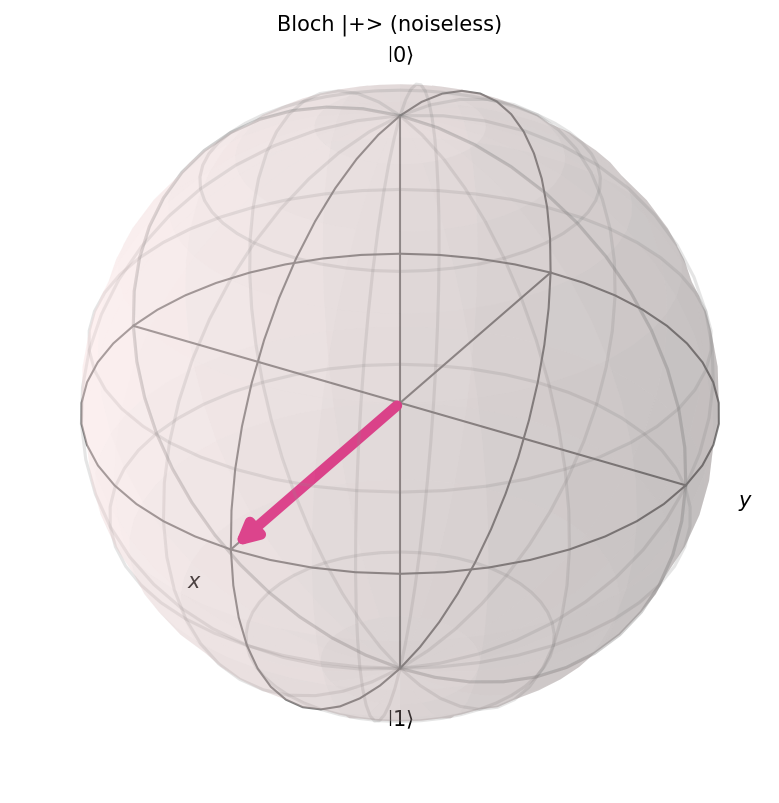
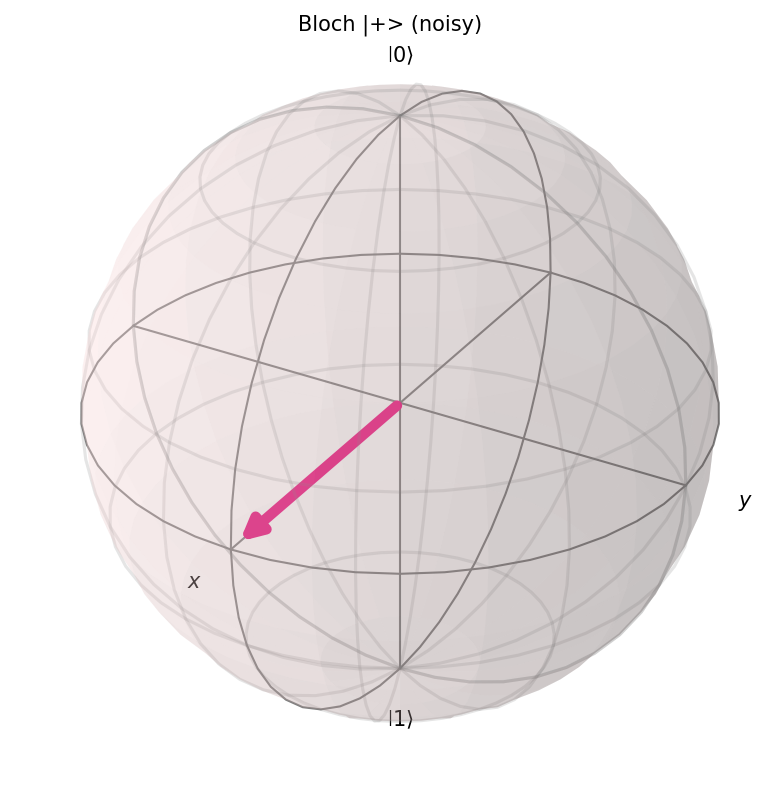


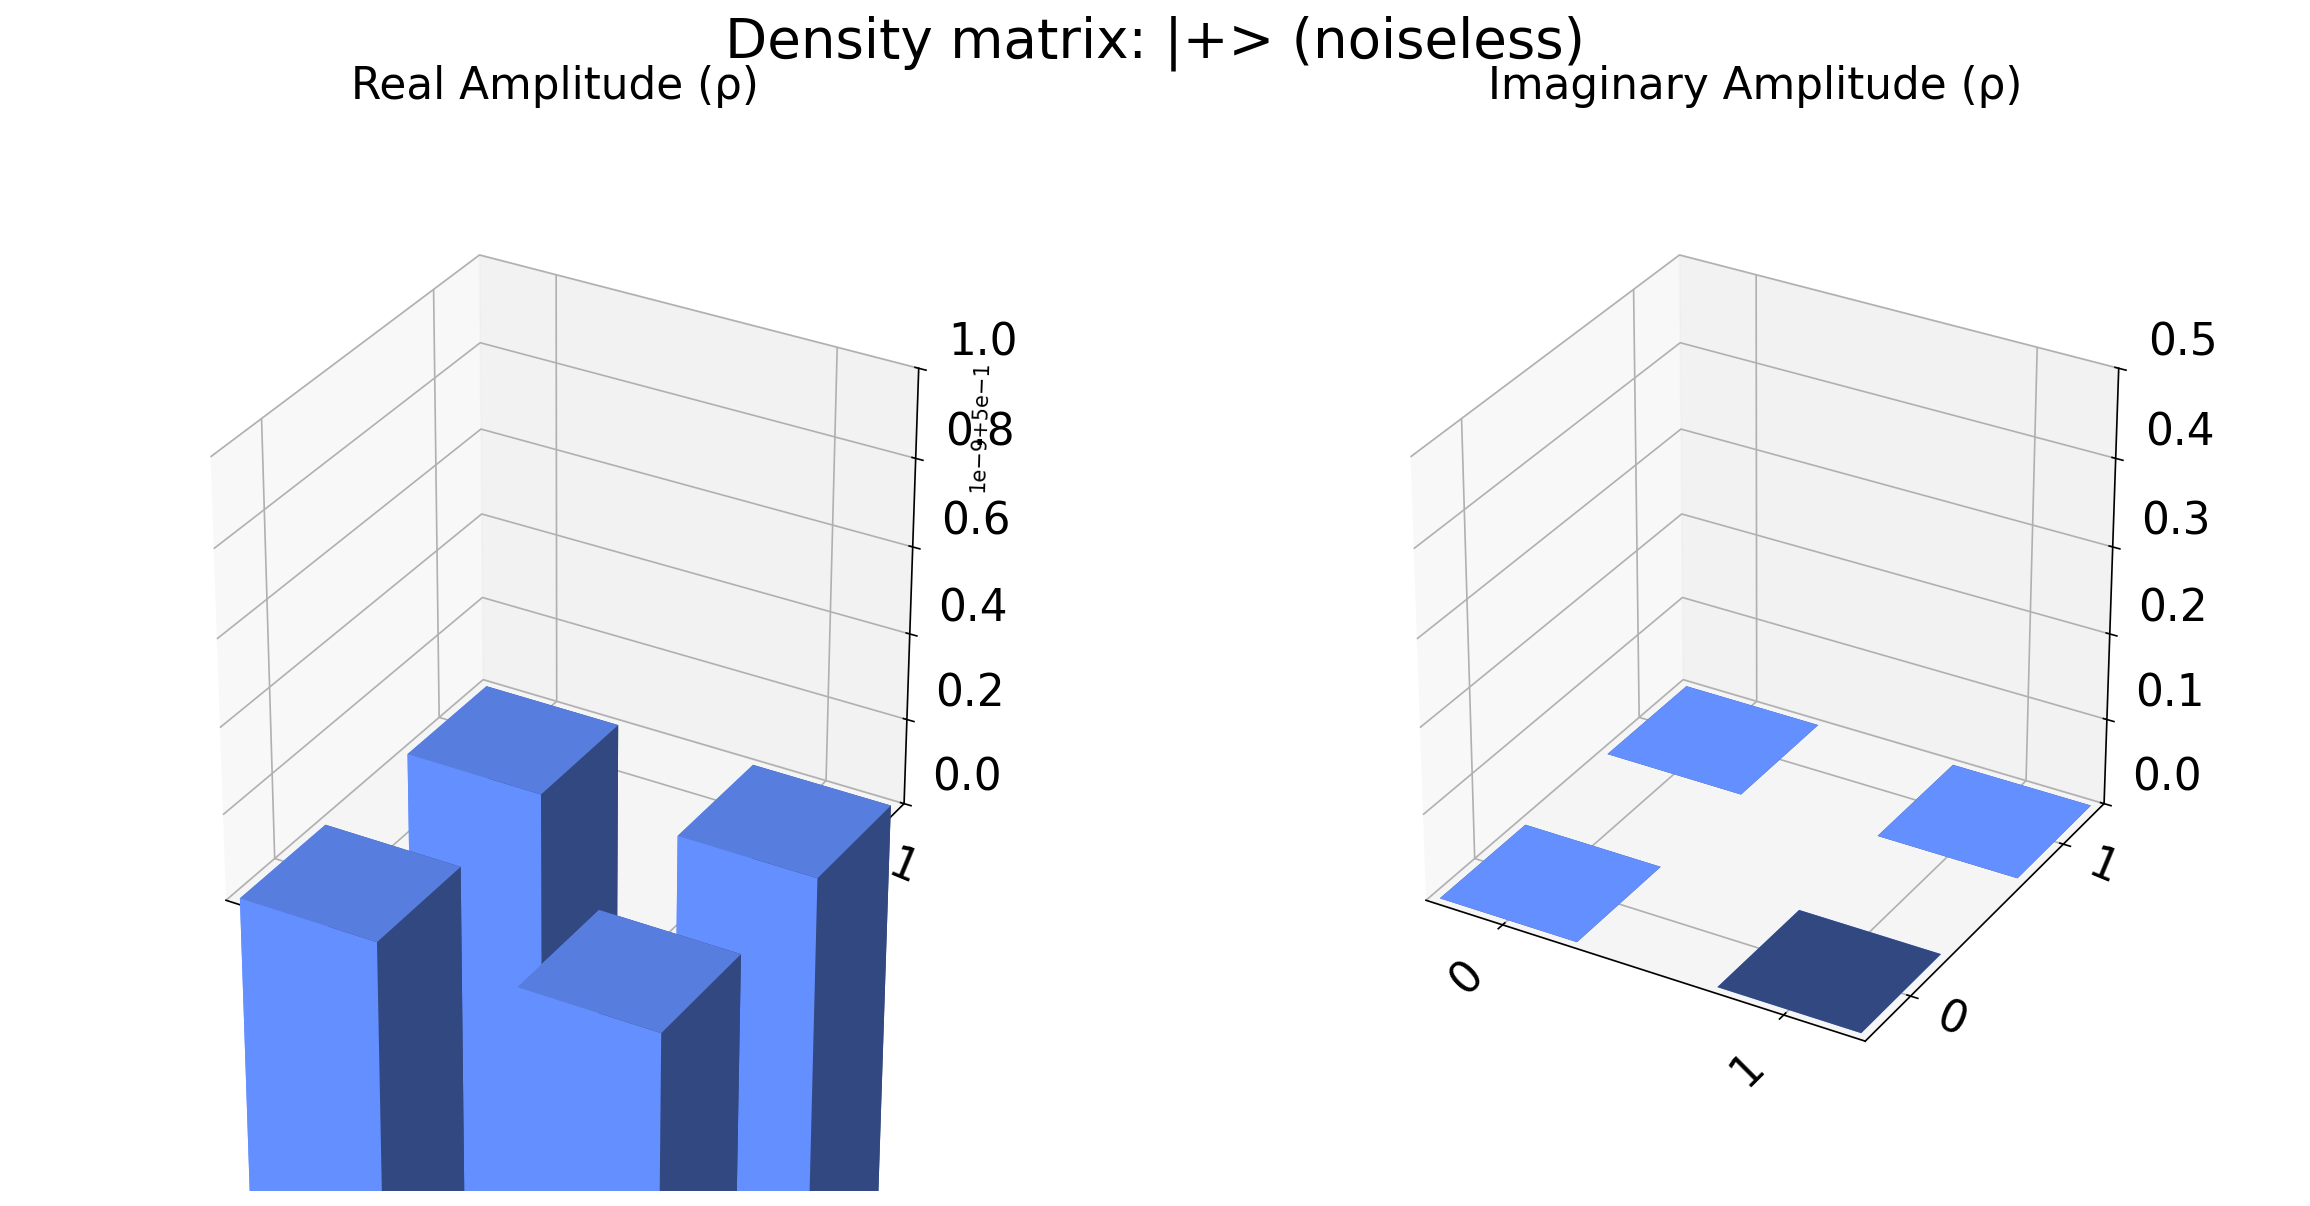
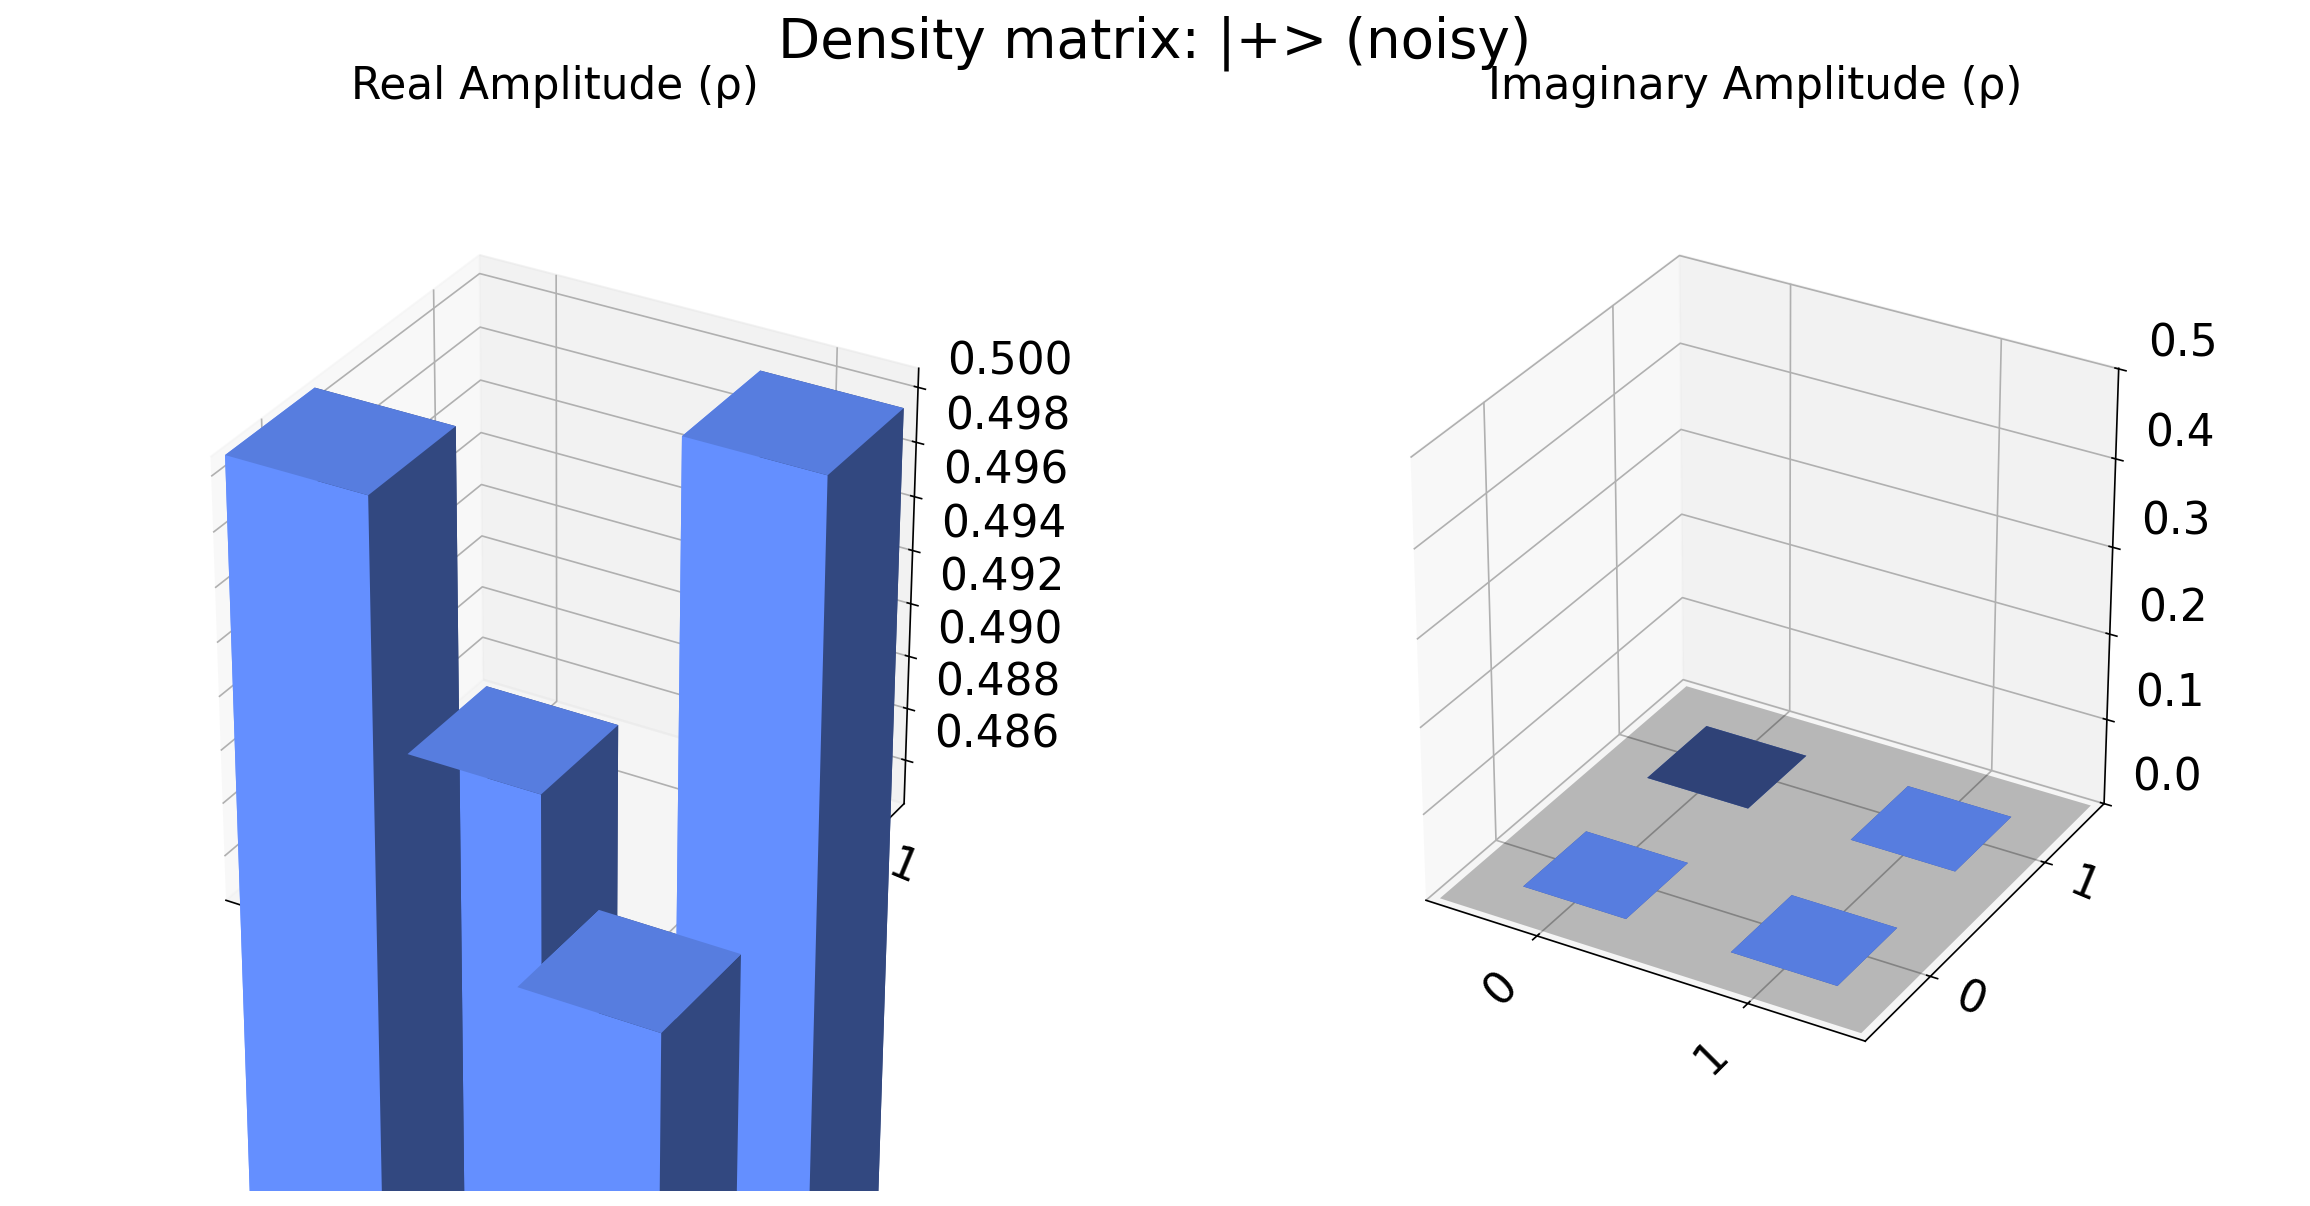

In [29]:
# Convert to qiskit DensityMatrix objects for the visualization helpers
dm_clean = DensityMatrix(rho_clean)
dm_noisy = DensityMatrix(rho_noisy)

# Bloch vectors
bv_clean = bloch_vector(rho_clean)
bv_noisy = bloch_vector(rho_noisy)

fig1 = plot_bloch_vector(bv_clean, title="Bloch |+> (noiseless)")
fig2 = plot_bloch_vector(bv_noisy, title="Bloch |+> (noisy)")
show_side_by_side([fig1, fig2], titles=["Noiseless", "Noisy"])

# Density-matrix “city” plots (real/imag bars)
fig3 = plot_state_city(dm_clean, title="Density matrix: |+> (noiseless)")
fig4 = plot_state_city(dm_noisy, title="Density matrix: |+> (noisy)")
show_side_by_side([fig3, fig4], titles=["Noiseless", "Noisy"])


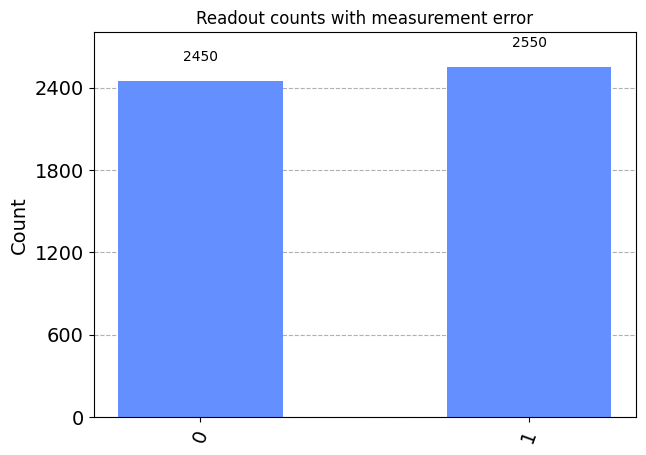

In [30]:
counts = res.get_counts()
fig7 = plot_histogram(counts, title="Readout counts with measurement error")
plt.show()


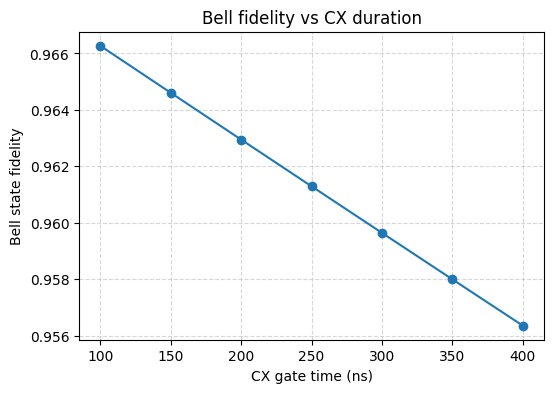

In [31]:
def bell_fidelity_vs_cx_time(cx_times, p2=0.02, T1=50e-6, T2=40e-6, p1=0.01, gate_time_1q=35e-9):
    fids = []
    # Build 1q combined noise once
    depol_1q = depolarizing_error(p1, 1)
    therm_1q = thermal_relaxation_error(T1, T2, gate_time_1q)
    combined_1q = therm_1q.compose(depol_1q)

    # Reference Bell (noiseless)
    bell = QuantumCircuit(2)
    bell.h(0); bell.cx(0,1)
    dm_clean = DensityMatrix(run_and_get_dm(bell, sim_dm_clean))

    for tau2q in cx_times:
        nm = NoiseModel()
        nm.add_all_qubit_quantum_error(combined_1q, ["id","rz","sx","x"])

        depol_2q = depolarizing_error(p2, 2)
        therm_2q = thermal_relaxation_error(T1, T2, tau2q).tensor(
            thermal_relaxation_error(T1, T2, tau2q)
        )
        combined_2q = therm_2q.compose(depol_2q)
        nm.add_all_qubit_quantum_error(combined_2q, ["cx"])

        sim_tmp = AerSimulator(method="density_matrix", noise_model=nm)
        dm_noisy = DensityMatrix(run_and_get_dm(bell, sim_tmp))
        fids.append(state_fidelity(dm_clean, dm_noisy))
    return np.array(fids)

# Sweep a range of CX times (in seconds)
cx_times = np.linspace(100e-9, 400e-9, 7)  # 100 ns → 400 ns
fids = bell_fidelity_vs_cx_time(cx_times)

plt.figure(figsize=(6,4))
plt.plot(cx_times*1e9, fids, marker="o")
plt.xlabel("CX gate time (ns)")
plt.ylabel("Bell state fidelity")
plt.title("Bell fidelity vs CX duration")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()
